## Review
### This recitation (10.18) covers following lecture below:
- **10.11 (Wed)**

In [ ]:
import numpy as np

### Optimization algorithms

#### Overview

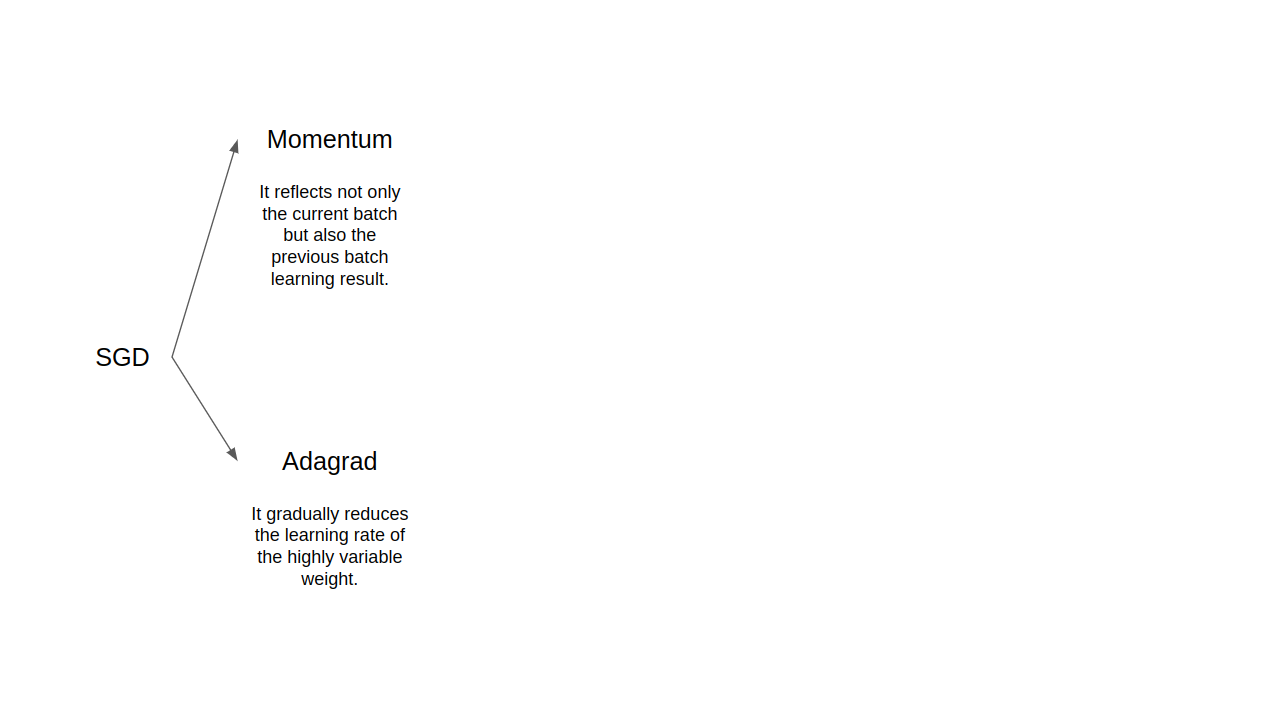

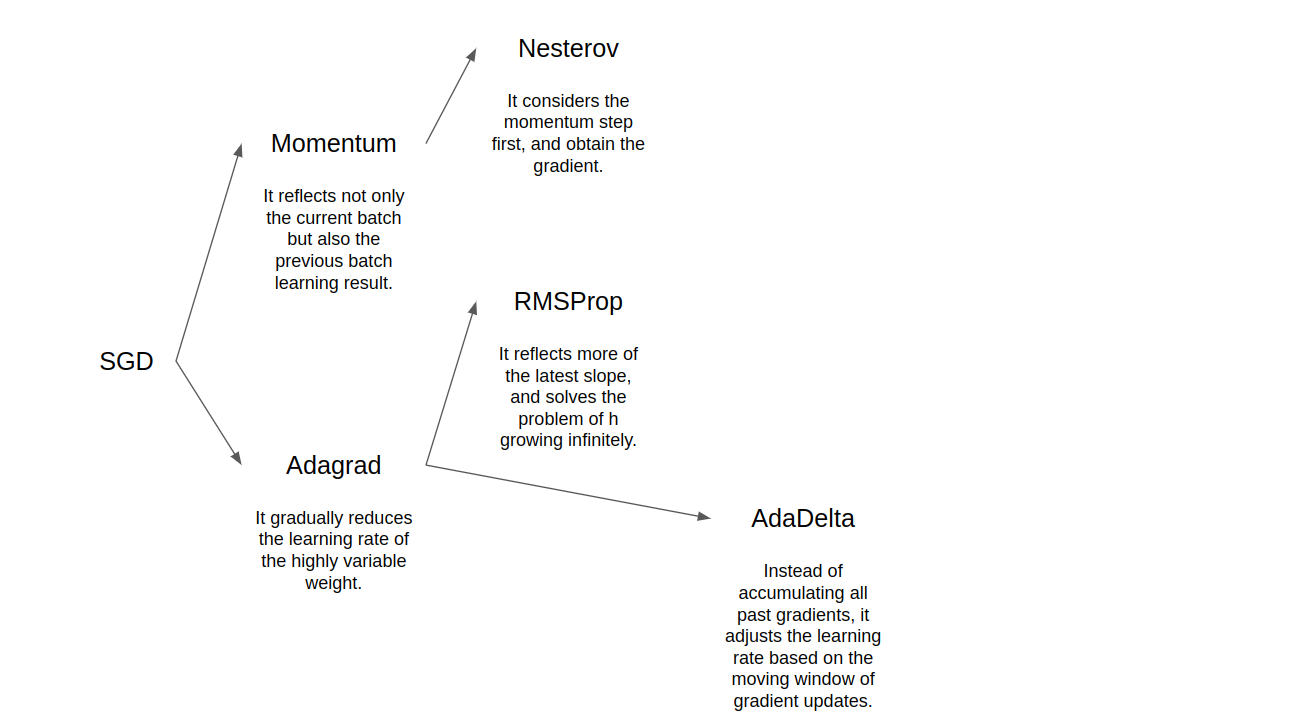

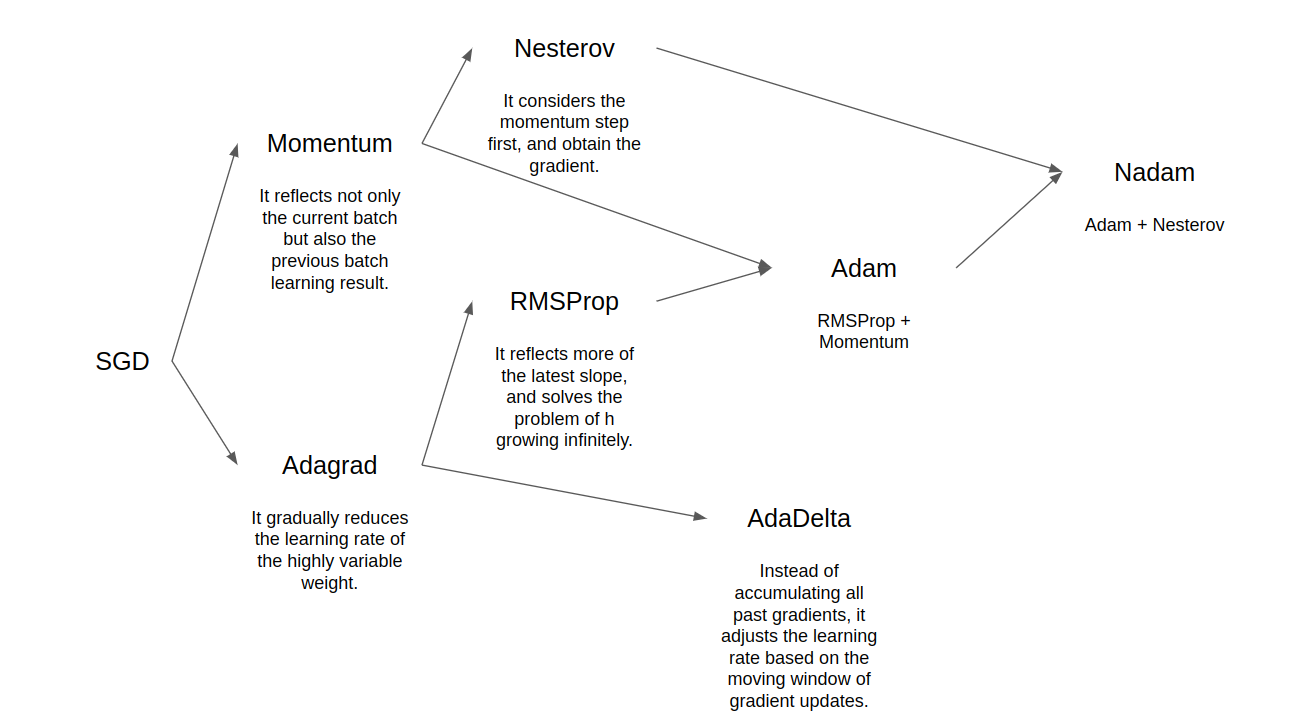

#### AdaDelta


*   Adagrad + RMSprop + Momentum
*   AdaDelta approximates second-order optimization.

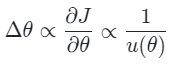

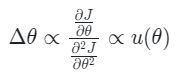

*   AdaDelta does not use learning rate.

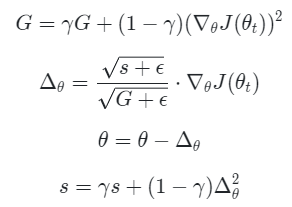

In [ ]:
class AdaDelta:
  def __init__(self, lr=1.0, rho=0.95):
    self.lr = lr
    self.rho = rho
    self.iter = 0
    self.epsilon = 1e-6
    self.m = None
    self.v = None
    self.delta = None

  def update(self, params, grads):
    if self.m is None:
      self.m, self.v, self.delta = {}, {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)
        self.delta[key] = np.zeros_like(val)

    self.iter += 1

    for key in params.keys():
      # 'ppp' exercise
      # YOUR CODE HERE
      self.m[key] = self.rho * self.m[key] + (1 - self.rho) * grads[key] ** 2
      self.v[key] = np.sqrt((self.delta[key] + self.epsilon) / (self.m[key] + self.epsilon)) * grads[key]
      params[key] -= self.v[key]
      self.delta[key] = self.rho * self.delta[key] + (1 - self.rho) * self.v[key] ** 2

#### Nadam


*   Adam with Nesterov Momentum
*   Nadam has the advantage of being able to find global minimums faster and more accurately than Adam.
*   The formula for adjusting momentum in Nesterov is as follows.

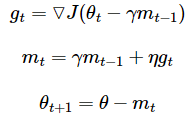


*   The formula for adjusting momentum in Nadam is as follows.

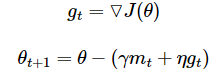

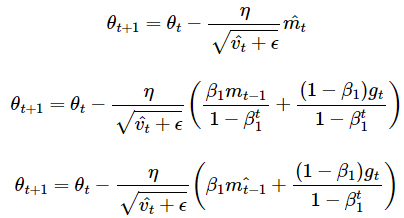

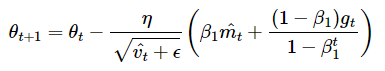

In [ ]:
class Nadam:
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None

  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)

    self.iter += 1

    for key in params.keys():
      # 'ppp' exercise
      # YOUR CODE HERE
      # Momentum
      self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
      m_hat = self.m[key] / (1 - self.beta1 ** self.iter)

      # RMSProp
      self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
      v_hat = self.v[key] / (1 - self.beta2 ** self.iter)

      # Update
      params[key] -= self.lr / (np.sqrt(v_hat) + 1e-7) * (self.beta1 * m_hat + (1 - self.beta1) * grads[key] / (1 - (self.b1 ** self.iter)))

### Application


#### Two-layer net

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
  return (1.0 - sigmoid(x)) * sigmoid(x)


def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x)  # to void overflow
  return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  if t.size == y.size:
    t = t.argmax(axis=1)

  batch_size = y.shape[0]

  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
class TwoLayerNet:

  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # initialize the weights
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

  # x : input data, t : ground-truth
  def loss(self, x, t):
    y = self.predict(x)

    return cross_entropy_error(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  # x : input data, t : ground-truth
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads

  def gradient(self, x, t):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']
    grads = {}

    batch_num = x.shape[0]

    # forward
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    # backward
    dy = (y - t) / batch_num

    # 'ppp' exercise
    grads['W2'] = np.dot(z1.T, dy)
    grads['b2'] = np.sum(dy, axis=0)

    da1 = np.dot(dy, W2.T)
    dz1 = sigmoid_grad(a1) * da1

    grads['W1'] = np.dot(x.T, dz1)
    grads['b1'] = np.sum(dz1, axis=0)

    return grads

#### Download MNIST

In [ ]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'https://github.com/WegraLee/deep-learning-from-scratch/raw/master/dataset/'
key_file = {
  'train_img':'train-images-idx3-ubyte.gz',
  'train_label':'train-labels-idx1-ubyte.gz',
  'test_img':'t10k-images-idx3-ubyte.gz',
  'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = '/content'  # Colab base dir
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
  file_path = dataset_dir + "/" + file_name

  if os.path.exists(file_path):
      return

  print("Downloading " + file_name + " ... ")
  urllib.request.urlretrieve(url_base + file_name, file_path)
  print("Done")

def download_mnist():
  for v in key_file.values():
    _download(v)

def _load_label(file_name):
  file_path = dataset_dir + "/" + file_name

  print("Converting " + file_name + " to NumPy Array ...")
  with gzip.open(file_path, 'rb') as f:
    labels = np.frombuffer(f.read(), np.uint8, offset=8)
  print("Done")

  return labels

def _load_img(file_name):
  file_path = dataset_dir + "/" + file_name

  print("Converting " + file_name + " to NumPy Array ...")
  with gzip.open(file_path, 'rb') as f:
    data = np.frombuffer(f.read(), np.uint8, offset=16)
  data = data.reshape(-1, img_size)
  print("Done")

  return data

def _convert_numpy():
  dataset = {}
  dataset['train_img'] =  _load_img(key_file['train_img'])
  dataset['train_label'] = _load_label(key_file['train_label'])
  dataset['test_img'] = _load_img(key_file['test_img'])
  dataset['test_label'] = _load_label(key_file['test_label'])

  return dataset

def init_mnist():
  download_mnist()
  dataset = _convert_numpy()
  print("Creating pickle file ...")
  with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)
  print("Done!")

def _change_one_hot_label(X):
  T = np.zeros((X.size, 10))
  for idx, row in enumerate(T):
    row[X[idx]] = 1

  return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
  """Read MNIST

  Parameters
  ----------
  normalize : Image pixel values become 0.0~1.0
  one_hot_label :
    encodes labels as one hot vectores
    an example of an one-hot : [0,0,1,0,0,0,0,0,0,0]
  flatten : makes the images 1-D vectors

  Returns
  -------
  (Train Images, Train Labels), (Test Images, Test Images)
  """
  if not os.path.exists(save_file):
      init_mnist()

  with open(save_file, 'rb') as f:
      dataset = pickle.load(f)

  if normalize:
      for key in ('train_img', 'test_img'):
          dataset[key] = dataset[key].astype(np.float32)
          dataset[key] /= 255.0

  if one_hot_label:
      dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
      dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

  if not flatten:
        for key in ('train_img', 'test_img'):
          dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

  return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

#### Optimizers

In [ ]:
class SGD:

  """Stochastic Gradient Descent"""

  def __init__(self, lr=0.01):
    self.lr = lr

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]

In [ ]:
class Adam:

  """Adam (http://arxiv.org/abs/1412.6980v8)"""

  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0  # for bias correction
    self.m = None
    self.v = None

  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)

    self.iter += 1
    lr_t = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)

    for key in params.keys():
      self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
      self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)

      params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

#### Training

In [ ]:
# read data
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

optimizer = Adam(lr=0.001)

# hyper-parameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# iteration per epoch
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
  # get minibatch
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # gradient calculation
  #grad = network.numerical_gradient(x_batch, t_batch)
  grad = network.gradient(x_batch, t_batch)

  # update parameters
  # 'ppp' exercise
  # YOUR CODE HERE
  optimizer.update(network.params, grad)

  # record training process
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  # log accuracy at the end of each epoch
  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"train acc, test acc | {train_acc:.4f}, {test_acc:.4f}")

# plot the result
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### Results


*   Without optimizer



```
for key in ('W1', 'b1', 'W2', 'b2'):
  network.params[key] -= learning_rate * grad[key]
```



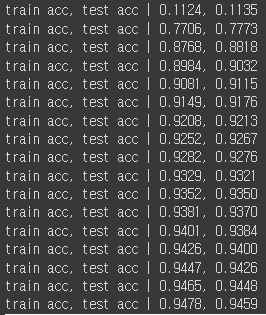

*   With Adam optimizer



```
optimizer.update(network.params, grad)
```



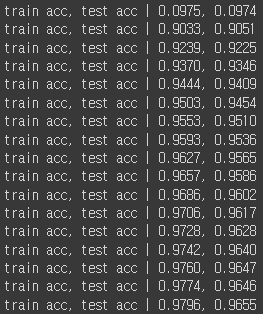



#### Comparison between optimizers

In [ ]:
# Choose the optimizer
optimizer = Adam(lr=0.001) # SGD, Adam, Nadam, AdaDelta ...

# hyper-parameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# iteration per epoch
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
  # get minibatch
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # gradient calculation
  #grad = network.numerical_gradient(x_batch, t_batch)
  grad = network.gradient(x_batch, t_batch)

  # update parameters
  optimizer.update(network.params, grad)

  # record training process
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  # log accuracy at the end of each epoch
  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"train acc, test acc | {train_acc:.4f}, {test_acc:.4f}")

# plot the result
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()